In [78]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
from __future__ import division

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [170]:
def plot_ising_grid(init, title=''):
    '''
    creates a discrete colormap for an input Ising grid
    red for up (1) and blue for down (-1)
    '''
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    display.clear_output(wait = True)

    plt.show()

In [197]:
def get_clustered_spins_to_flip(flattened_grid, s, neighboring_iis, flip_prob):
    '''
    builds up a link of points to eventually cluster and then flip spins
    with probability flip_prob
    
    the link starts from point s; for each neighbor 'n' of each point in the link 'l', if the
    spins are the same, the neighbor isn't already in the cluster, and p <= flip_prob, then
    the point is added to the link and the cluster, after which the original point 'l' is 
    removed from the link
    
    eventually, all the points in the links are exhausted and there are no more points 
    left to explore in the link. at this point, the points in the cluster are returned.
    
    adapted from the pseudocode in https://arxiv.org/pdf/cond-mat/0311623v1.pdf
    '''
    # link = np.array([s])
    link = np.zeros_like(flattened_grid)
    link[s] = 1
    cluster_iis = np.array([s])
    
    while link.sum() > 0:
        l = np.random.choice([x for x in range(len(link)) if link[x]==1])
        for n in neighboring_iis[l]:
            if (flattened_grid[n] == flattened_grid[l] and n not in cluster_iis 
                and np.random.rand() <= flip_prob):
                # link = np.append(link, n)
                link[n] = 1
                cluster_iis = np.append(cluster_iis, n)
        # link = np.delete(link, np.where(link==l)[0])
        link[l] = 0
    
    return np.array(cluster_iis, dtype=int)

In [198]:
def wolff(init, L, J, T, nsteps):
    '''
    applies the wolff clustering algorithm to this ising state
    
    '''
    N = L * L
    flip_prob = 1-np.exp(-2*J/T)

    # treats the 2D array into a 1D array ("flattened") to find the neighboring indexes 
    # neighbors are directly above, below, or next to the point and wraps around
    # format: 
    #   {index: [neighbor to the "left", neighbor to the "right", neighbor "below", neighbor "above"]}
    neighboring_iis = {i : [(i//L)*L + (i-1)%L, (i//L)*L + (i+1)%L,
                            (i+L)%N, (i-L)%N] for i in range(N)}

    grid = init[:]
    for i in range(nsteps):
        flattened_grid = grid.reshape([N])
        
        # choose a random spin index s in the grid
        s = np.random.randint(N) 
        cluster_iis = get_clustered_spins_to_flip(flattened_grid, s, neighboring_iis, flip_prob)

        # after above process is done, flip the spins in the cluster
        flattened_grid[cluster_iis] *= -1

        # plot the updated wolff grid
        grid = flattened_grid.reshape([L,L])
        plot_ising_grid(grid)

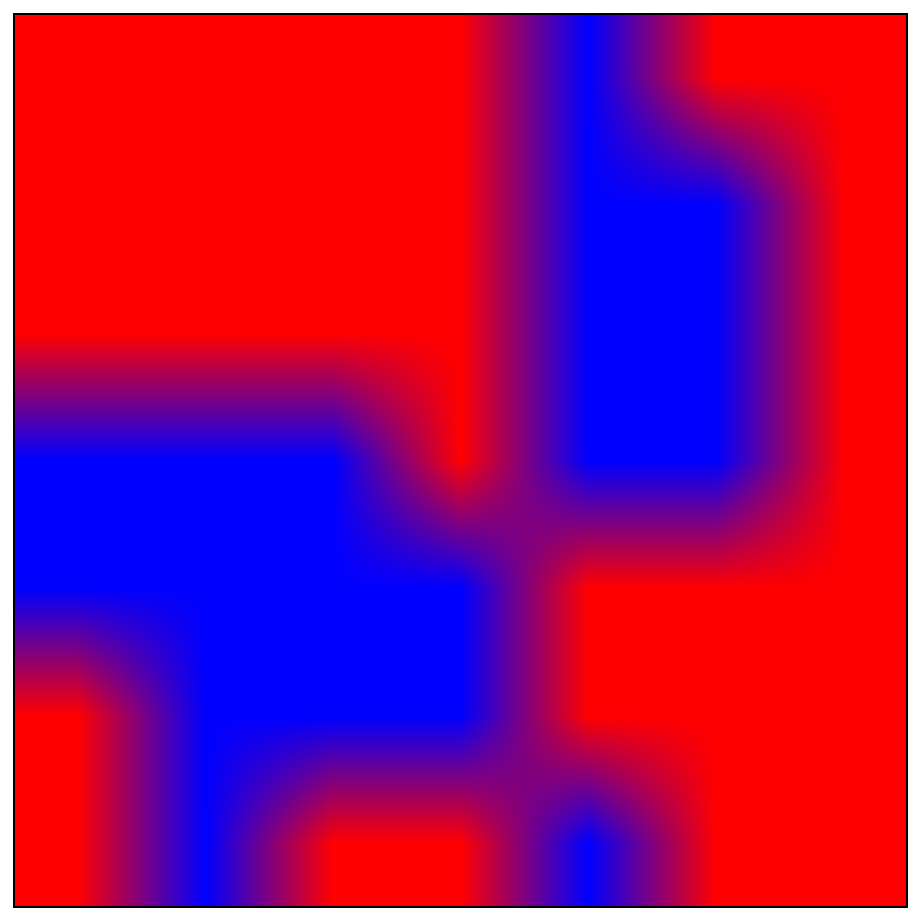

CPU times: user 5.75 s, sys: 132 ms, total: 5.88 s
Wall time: 6.14 s


In [199]:
T = 2.5
J = 1
L = 7
nsteps = 10
init = np.reshape([random.choice([1, -1]) for k in range(L*L)], (L,L))
%time wolff(init, L, J, T, nsteps)